# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \text{ cm}$ and the wheel radius is $r = 12.5 \text{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 


In [2]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

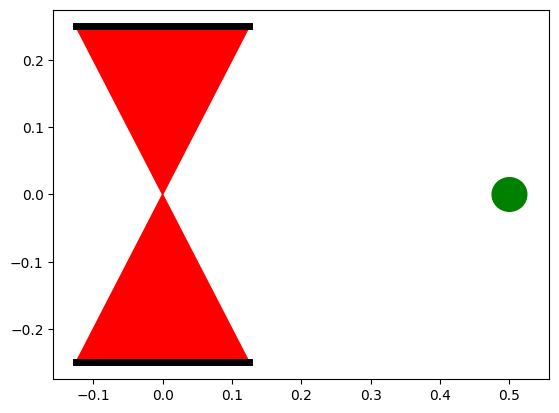

In [3]:
from matplotlib import pyplot as plt, patches

def draw_scooter(x,y,theta) :
    #Center of the right wheel
    x1 = x + sin(theta)*l/2
    y1 = y - cos(theta)*l/2

    #Center of the left wheel
    x2 = x - sin(theta)*l/2
    y2 = y + cos(theta)*l/2

    #Right Wheel 
    x1_ = linspace(x1-cos(theta)*r,x1+cos(theta)*r, 100)
    y1_ = linspace(y1-sin(theta)*r,y1+sin(theta)*r, 100)

    plot(x1_, y1_, '-', linewidth = 5, color = 'black')

    #Left Wheel
    x2_ = linspace(x2-cos(theta)*r,x2+cos(theta)*r, 100)
    y2_ = linspace(y2-sin(theta)*r,y2+sin(theta)*r, 100)

    plot(x2_, y2_, '-', linewidth = 5, color = 'black')

    #Pads of the scooter
    plt.fill([x1-cos(theta)*r,x,x1+cos(theta)*r],[y1-sin(theta)*r,y,y1+sin(theta)*r], alpha=1, color = 'red')
    plt.fill([x2+cos(theta)*r,x,x2-cos(theta)*r],[y2+sin(theta)*r,y,y2-sin(theta)*r], alpha=1, color = 'red')

    #Circle Marker
    circle = plt.Circle((x + 0.5*cos(theta), y+ 0.5*sin(theta)), 0.025, color='green')
    plt.gca().add_patch(circle)
    
    
  
draw_scooter(0,0,0)

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

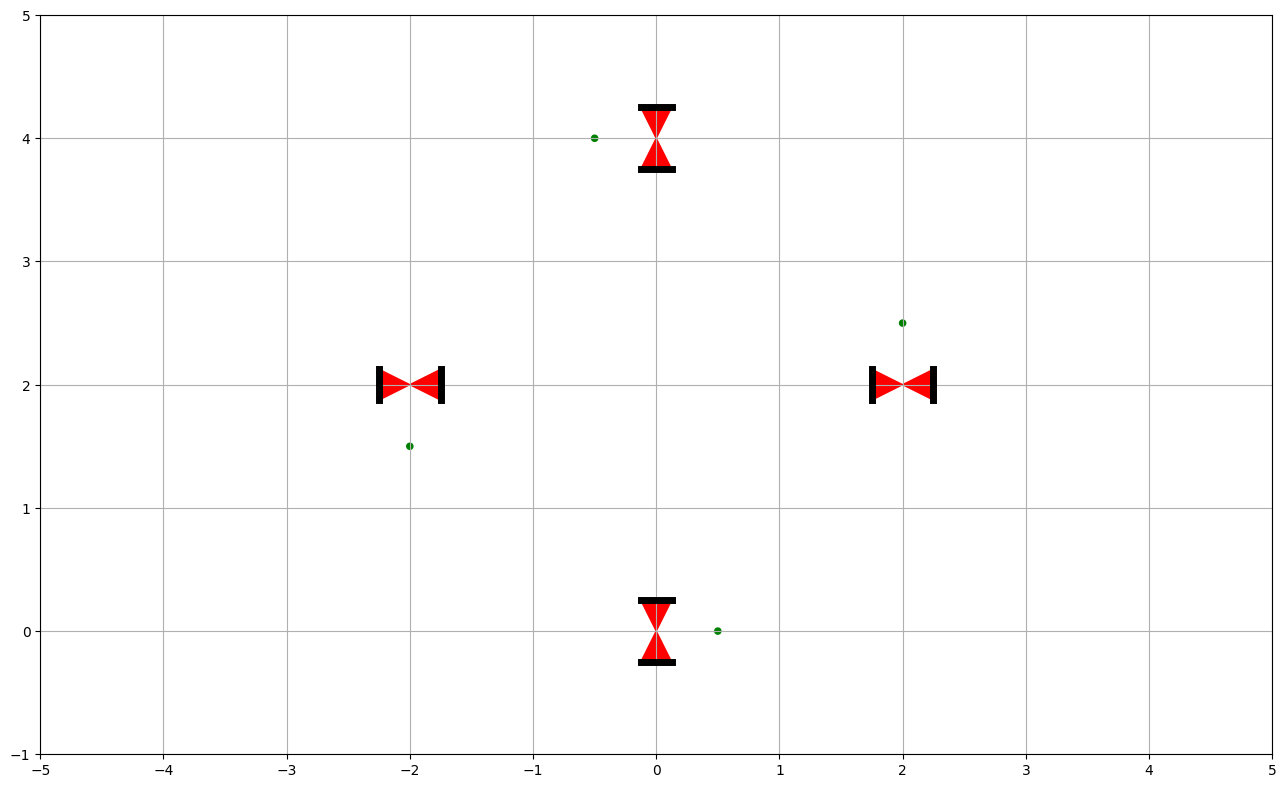

In [5]:
draw_arena(-5,5,-1,5)
plt.rc('axes', axisbelow=True)
draw_scooter(0,0,0)
draw_scooter(2,2,pi/2)
draw_scooter(0,4,pi)
draw_scooter(-2,2,3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer :**

The velocity of the wheels is as follows :

Right Wheel :        $V_r = \omega_r * r$

Left wheel :     $V_l = \omega_l * r$     

The velocity of the whole system will then be :  $V  = \frac{V_l + V_r}{2}$

We know that :
\begin{equation}
    \begin{cases}
      \dot{x} = V * cos(Θ)\\
      \dot{y} = V * sin(Θ)
    \end{cases}\
\end{equation}

So :
\begin{equation}
    \begin{cases}
      \dot{x} = \frac{V_l + V_r}{2} * cos(Θ)\\
      \dot{y} = \frac{V_l + V_r}{2} * sin(Θ)
    \end{cases}\
\end{equation}

Finally we get the following results :
\begin{equation}
    \begin{cases}
      \dot{x} = \frac{(\omega_l + \omega_r)*r}{2} * cos(Θ)\\
      \dot{y} = \frac{(\omega_l + \omega_r)*r}{2} * sin(Θ)
    \end{cases}\
\end{equation}

On the other hand, we have :
$\dot{Θ} = \frac{V_r - V_l}{l}$

Hence : 
$\dot{Θ} = \frac{(\omega_r - \omega_l)*r}{l}$

The differential equations are :
\begin{equation}
    \begin{cases}
      \dot{x} = r*\frac{(\omega_l + \omega_r)}{2} * cos(Θ)\\
      \dot{y} = r*\frac{(\omega_l + \omega_r)}{2} * sin(Θ)\\
      \dot{Θ} = r*\frac{(\omega_r - \omega_l)}{l}
    \end{cases}\
\end{equation}

**TODO**

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer**

To Prove the well-posedness of the system, we need to establish the existence, uniqueness, and continuous dependence of solutions on initial conditions.

1. **Existence of Solutions**: We can utilize the existence theorem for ordinary differential equations. This theorem guarantees the existence of solutions under certain conditions on the functions involved. In our case, since \( $\omega_l $) and \( $\omega_r $) are continuously differentiable functions, the conditions for the existence theorem are satisfied, and therefore, solutions exist.

2. **Uniqueness of Solutions**: We can use the uniqueness theorem for ordinary differential equations. This theorem states that if the functions involved are sufficiently smooth, then the solution is unique. Since \( $\omega_l $) and \( $\omega_r $) are continuously differentiable, the conditions for the uniqueness theorem are also met, and thus solutions are unique.

3. **Continuity**: Since \( $\omega_l $) and \( $\omega_r $) are continuously differentiable, their derivatives are bounded in a certain neighborhood. We can use this boundedness to establish the Lipschitz continuity of the system's right-hand side, ensuring the continuous dependence of solutions on initial conditions.

By establishing these three properties, we can conclude that the system is well-posed when \( $\omega_l $) and \( $\omega_r $)are continuously differentiable functions of $ (x, y, \theta) $.

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer**

### Case 1: \($\omega_l)$ and $(\omega_r)$ are constants

If \($\omega_l)$ and $(\omega_r)$  are constants, we can show that the maximal solution associated with any initial state is global. Let's analyze the system of differential equations:


\begin{cases}
\dot{x} = \frac{r}{2} (\omega_l + \omega_r) \cos(\theta) \\
\dot{y} = \frac{r}{2} (\omega_l + \omega_r) \sin(\theta) \\
\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l)
\end{cases}


Given \($\omega_l)$ and $(\omega_r)$ are constants, the system can be solved as follows:

1. **Solve for \($\theta(t)$):**
   \[
   $\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) = \text{constant}$
   \]
   Let $(\alpha = \frac{r}{l} (\omega_r - \omega_l))$. Then:
   \[
   $\theta(t) = \theta_0 + \alpha t$
   \]
   where $(\theta_0)$ is the initial orientation at \(t = 0\).

2. **Solve for \(x(t)\) and \(y(t)\):**
   Let $(\beta = \frac{r}{2} (\omega_l + \omega_r))$. Then:
   \[
   $\dot{x} = \beta \cos(\theta) = \beta \cos(\theta_0 + \alpha t)$
   \]
   \[
   $\dot{y} = \beta \sin(\theta) = \beta \sin(\theta_0 + \alpha t)$
   \]

   These equations represent the motion of the robot in polar coordinates. The solutions to these differential equations are:

   \[
   $x(t) = x_0 + \int_0^t \beta \cos(\theta_0 + \alpha \tau) \, d\tau$
   \]

   $[
   y(t) = y_0 + \int_0^t \beta \sin(\theta_0 + \alpha \tau) \, d\tau$
   \]

   Given that $(\cos)$ and $(\sin)$ are bounded and continuous functions, these integrals will always exist for all $(t \geq 0)$. Therefore, $(x(t))$ and $(y(t))$ are well-defined for all $(t \geq 0)$.

Since the solutions $(x(t))$, $(y(t))$, and $(\theta(t))$ are well-defined for all time $(t)$, the maximal solution is global.



### Case 2: \($\omega_l) and (\omega_r)$ are continuously differentiable functions of $(x, y, \theta)$

Now, consider the case where \($\omega_l)$ and $(\omega_r)$ are continuously differentiable functions of $(x, y, \theta)$. The system becomes:


\begin{cases}
\dot{x} = \frac{r}{2} (\omega_l(x, y, \theta) + \omega_r(x, y, \theta)) \cos(\theta) \\
\dot{y} = \frac{r}{2} (\omega_l(x, y, \theta) + \omega_r(x, y, \theta)) \sin(\theta) \\
\dot{\theta} = \frac{r}{l} (\omega_r(x, y, \theta) - \omega_l(x, y, \theta))
\end{cases}

Sure, let's delve into that.

In Case 2, where \(\omega_l\) and \(\omega_r\) are continuously differentiable functions of \((x, y, \theta)\), the system becomes:

\begin{cases}
\dot{x} = \frac{r}{2} (\omega_l(x, y, \theta) + \omega_r(x, y, \theta)) \cos(\theta) \\
\dot{y} = \frac{r}{2} (\omega_l(x, y, \theta) + \omega_r(x, y, \theta)) \sin(\theta) \\
\dot{\theta} = \frac{r}{l} (\omega_r(x, y, \theta) - \omega_l(x, y, \theta))
\end{cases}

To show that the maximal solution is not global, we would need to find a counter-example where the solutions blow up in finite time or encounter singularities.

Here's a simple counter-example:

Consider the following functions:

\begin{align*}
\omega_l(x, y, \theta) &= x^2 + y^2 \\
\omega_r(x, y, \theta) &= \theta + 1
\end{align*}

Let's analyze the system's behavior with these functions:

\begin{cases}
\dot{x} = \frac{r}{2} ((x^2 + y^2) + (\theta + 1)) \cos(\theta) \\
\dot{y} = \frac{r}{2} ((x^2 + y^2) + (\theta + 1)) \sin(\theta) \\
\dot{\theta} = \frac{r}{l} ((\theta + 1) - (x^2 + y^2))
\end{cases}

In this case, as $(x^2 + y^2)$ increases, the terms $(\omega_l$) and $(\omega_r)$ grow without bounds. This can lead to solutions where the velocities become unbounded, causing the system to blow up in finite time, indicating that the maximal solution is not global.

This counter-example illustrates that under certain conditions where the functions $(\omega_l$) and $(\omega_r)$ grow too quickly or have discontinuities, the maximal solution may not be globally defined.

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [16]:
def fun(t, xytheta):
  x, y, theta = xytheta
  omega_l, omega_r = omega(t, xytheta)
  vx=(omega_l +omega_r)*r*cos(theta)/2
  vy=(omega_l +omega_r)*r*sin(theta)/2
  thetap=(omega_r -omega_l)*r/l
  return array([vx,vy,thetap])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \text{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \text{ rad/s}$.
(Compute the dense outputs.)
   

In [17]:
results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

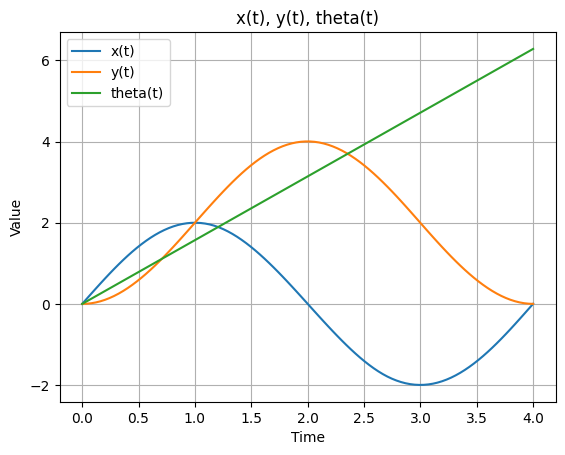

In [18]:
# Extract the solution
t = np.linspace(0, 4, 100)  
sol = results.sol(t)

# Plot x, y, and theta over time
plt.plot(t, sol[0], label='x(t)')
plt.plot(t, sol[1], label='y(t)')
plt.plot(t, sol[2], label='theta(t)')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('x(t), y(t), theta(t)')
plt.legend()
plt.grid(True)

plt.show()

🧩 Use the simulation results to display the robot location every 0.5 second.

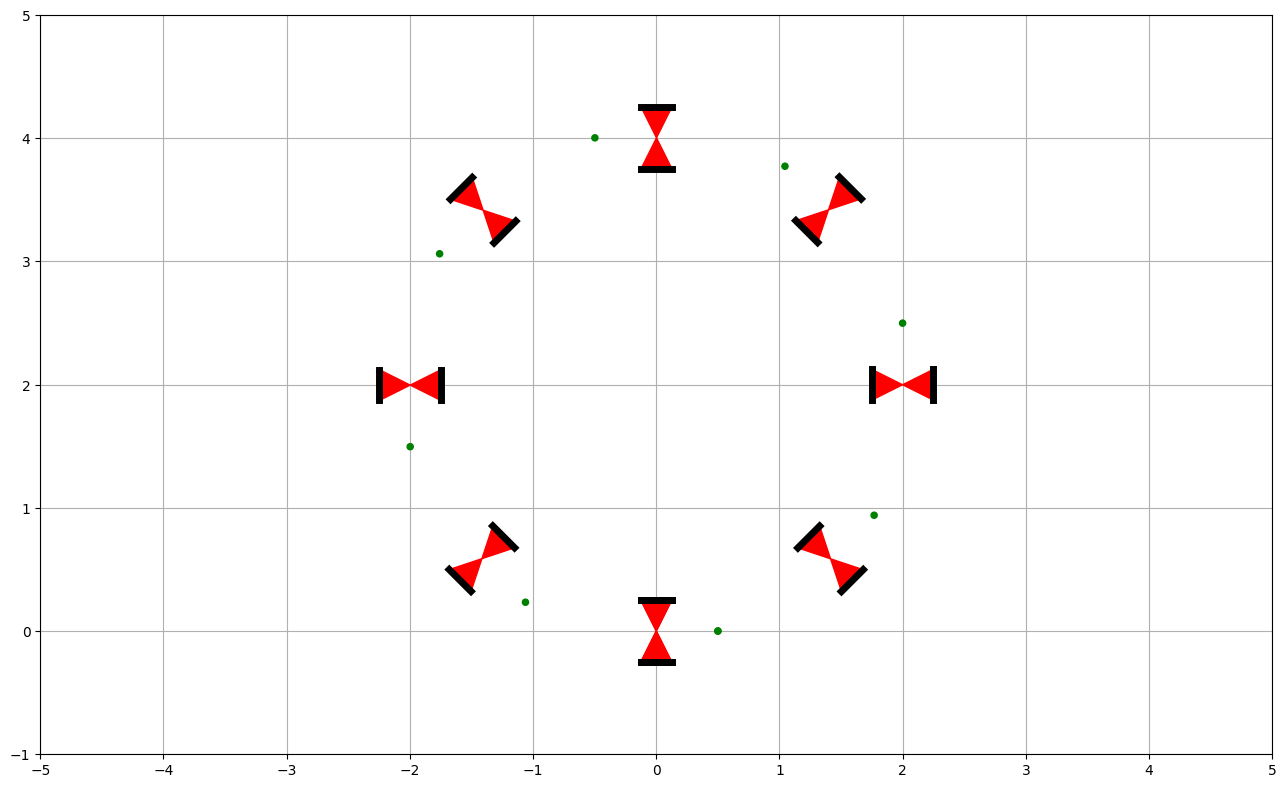

In [20]:
draw_arena(-5,5,-1,5)
t = linspace(0.0, 4.0, 9)
solution = results["sol"](t)
for x, y, theta in solution.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer**
We have :
\begin{equation}
    \begin{cases}
      \dot{x} = r*\frac{(\omega_l + \omega_r)}{2} * cos(Θ)\\
      \dot{y} = r*\frac{(\omega_l + \omega_r)}{2} * sin(Θ)\\
      \dot{Θ} = r*\frac{(\omega_r - \omega_l)}{l}
    \end{cases}\
\end{equation}

By integrating the system, we get :
\begin{equation}
    \begin{cases}
      x = r*\frac{(\omega_l + \omega_r)}{2} * \frac{sin(Θ)}{\dot{Θ}} + cte1 \\
      y = - r*\frac{(\omega_l + \omega_r)}{2} * \frac{cos(Θ)}{\dot{Θ}} + cte2\\
      Θ = r*\frac{(\omega_r - \omega_l)}{l}*t + cte3
    \end{cases}\
\end{equation}
For $t = 0$ we have $(x_0,y_0,Θ_0) = (0,0,0)$
So : 
\begin{cases}
      x_0 = 0 + cte1 = 0 \\
      y_0 = - r*\frac{(\omega_l + \omega_r)}{2\dot{Θ}} + cte2 = 0 \\
      Θ_0 = 0 + cte3 = 0 
    \end{cases}
Which leads to :
\begin{cases}
      cte1 = 0 \\
      cte2 =  r*\frac{(\omega_l + \omega_r)}{2\dot{Θ}}\\
      cte3 = 0 
    \end{cases}
And by writing the expression of dot{Θ} in the system (2), we get :     
\begin{equation}
    \begin{cases}
      x = \frac{l}{2}*\frac{\omega_r + \omega_l}{\omega_r - \omega_l} * sin(Θ)  \\
      y = \frac{l}{2}*\frac{\omega_r + \omega_l}{\omega_r - \omega_l} *(1- cos(Θ))\\
      Θ = r*\frac{(\omega_r - \omega_l)}{l}*t
    \end{cases}\
\end{equation}

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

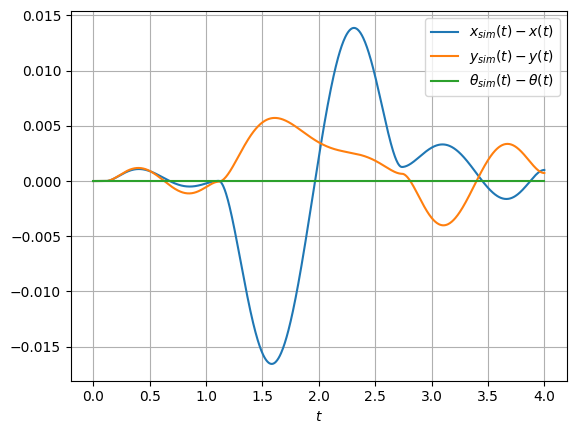

In [22]:
wl, wr = omega(0, [0,0,0])
def x(t):
    return l/2*(wl + wr)/(wr-wl)*sin(theta(t))
def y(t):
    return  l/2*(wl + wr)/(wr-wl)*(1-cos(theta(t)))
def theta(t):
    return r/l*(wr-wl)*t
figure()

results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)
t = linspace(0, 4, 1000)
sol = results['sol']
plot(t, sol(t)[0] - x(t), "-", label="$x_{sim}(t) - x(t)$")
plot(t, sol(t)[1] - y(t), "-", label="$y_{sim}(t) - y(t)$")
plot(t, sol(t)[2] - theta(t), "-", label="$θ_{sim}(t) - θ(t)$")

xlabel("$t$"); grid(); legend()


🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

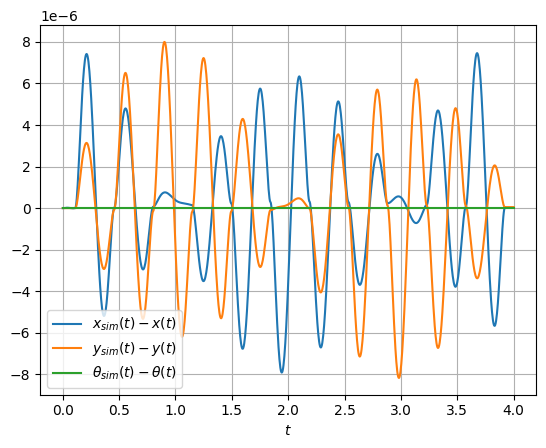

In [23]:
results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output = True, atol = 1e-6, rtol = 1e-8)
sol = results["sol"]
figure()
t = linspace(0, 4, 1000)

plot(t, sol(t)[0] - x(t), "-", label="$x_{sim}(t) - x(t)$")
plot(t, sol(t)[1] - y(t), "-", label="$y_{sim}(t) - y(t)$")
plot(t, sol(t)[2] - theta(t), "-", label="$θ_{sim}(t) - θ(t)$")

xlabel("$t$"); grid(); legend()